# Notebook 6.4: MPC with Gaussian Process (GP) Models (GP-MPC) using GPyTorch

This notebook explores using **Gaussian Processes (GPs)** for data-driven MPC. We will use **GPyTorch**, a modern, flexible library for building GP models in PyTorch.

GPs are a Bayesian, non-parametric approach that provide both a mean prediction and, crucially, a measure of **uncertainty** (variance). We will train a GPyTorch model to learn system dynamics and discuss how it fits into the MPC framework, highlighting the utility of uncertainty quantification.

**Goals of this Notebook:**
1.  Introduce Gaussian Processes using the PyTorch-native `GPyTorch` library.
2.  Train a GPyTorch model to learn the one-step-ahead dynamics of a nonlinear system.
3.  Visualize the GPyTorch model's mean prediction and confidence intervals.
4.  Discuss the challenge of integrating PyTorch-based models (GPyTorch) with CasADi-based NMPC.
5.  Simulate a conceptual NMPC loop (using the analytical model for internal MPC predictions) to illustrate the control framework.
6.  Discuss how GP uncertainty can inform robust MPC and how libraries like `BoTorch` leverage this for Bayesian Optimization and Active Learning.

## 1. Importing Libraries

**Installation (if you haven't already):**
Make sure your virtual environment from Notebook 0.0 is activated.
```bash
uv pip install gpytorch botorch # botorch for Bayesian Opt / Active Learning (uses gpytorch)
```
*(Note: We use BoTorch conceptually here, not in a full active-learning MPC example, which is a highly advanced topic)*.

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import casadi as ca

import torch
import gpytorch
import botorch # Mentioned for context
import math

# Optional: for nicer plots
plt.rcParams.update({'font.size': 12, 'figure.figsize': (10, 6)})

## 2. The Nonlinear System and Data Generation

We reuse the 1D nonlinear system from the previous GP draft:
$$ \frac{dx}{dt} = -x + 0.5 x^3 + u $$

In [20]:
# Simple 1D Nonlinear System ODE
def nonlinear_system_ode(t, x, u_input):
    dxdt = -x + 0.5*x**3 + u_input 
    return dxdt

Ts_gp_data = 0.1 # Sampling time for data generation

# Generate Training/Validation/Test Data
N_gp_total_samples = 300 # GPs often work well with less data than ANNs
x_gp_data_list = []
u_gp_data_list = []
x_next_gp_data_list = []

x_current_gp = np.array([0.5]) # Initial state (1D)
np.random.seed(123)

print("Generating data for GP training...")
for i in range(N_gp_total_samples):
    u_current_gp = np.random.uniform(-1.5, 1.5) # Random input
    x_gp_data_list.append(x_current_gp.copy())
    u_gp_data_list.append(u_current_gp)
    
    sol = solve_ivp(nonlinear_system_ode, [0, Ts_gp_data], x_current_gp, 
                      args=(u_current_gp,), method='RK45', dense_output=False)
    x_next_gp = sol.y[:, -1]
    x_next_gp_data_list.append(x_next_gp.copy())
    
    x_current_gp = x_next_gp + np.random.normal(0, 0.01) # Add process noise
    x_current_gp = np.clip(x_current_gp, -2.5, 2.5) # Keep it bounded

# --- Convert to Tensors ---
x_gp_data_np = np.array(x_gp_data_list)
u_gp_data_np = np.array(u_gp_data_list).reshape(-1, 1)
x_next_gp_data_np = np.array(x_next_gp_data_list)

# Inputs to GP: [x_k, u_k]
GP_input_X_np = np.hstack((x_gp_data_np, u_gp_data_np))
# Outputs of GP: delta_x_k = x_k+1 - x_k (Target)
GP_delta_Y_np = x_next_gp_data_np - x_gp_data_np 

# Convert training data to PyTorch tensors
train_x = torch.tensor(GP_input_X_np, dtype=torch.float32)
train_y = torch.tensor(GP_delta_Y_np, dtype=torch.float32).flatten() # Needs to be 1D for ExactGP

print("Data generation complete.")
print(f"Train_x shape: {train_x.shape}, Train_y shape: {train_y.shape}")

Generating data for GP training...
Data generation complete.
Train_x shape: torch.Size([300, 2]), Train_y shape: torch.Size([300])


## 3. Training the GPyTorch Model

We define a model inheriting from `gpytorch.models.ExactGP`, specify a Mean and Kernel, and use the `gpytorch.mlls.ExactMarginalLogLikelihood` as the loss function to train the kernel hyperparameters.

In [21]:
# 1. GP Model Definition
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        # RBF Kernel with ARD (Automatic Relevance Determination = separate lengthscale per input dim)
        self.covar_module = gpytorch.kernels.ScaleKernel(
             gpytorch.kernels.RBFKernel(ard_num_dims=train_x.shape[1])
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# 2. Initialize Likelihood and Model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
gp_torch_model = ExactGPModel(train_x, train_y, likelihood)

# 3. Training Loop
training_iter = 150
optimizer_gp = torch.optim.Adam(gp_torch_model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp_torch_model)

print("Training GPyTorch model...")
gp_torch_model.train()
likelihood.train()

for i in range(training_iter):
    optimizer_gp.zero_grad()
    output = gp_torch_model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    if (i + 1) % 20 == 0:
      print(f'Iter {i+1}/{training_iter} - Loss: {loss.item():.3f}   '
            f'lengthscale: {gp_torch_model.covar_module.base_kernel.lengthscale.detach().numpy()}   '
            f'noise: {likelihood.noise.item():.3f}')
    optimizer_gp.step()

print("GPyTorch training complete.")

# Set to evaluation mode
gp_torch_model.eval()
likelihood.eval()

Training GPyTorch model...
Iter 20/150 - Loss: -0.057   lengthscale: [[1.8040116 1.8621768]]   noise: 0.136
Iter 40/150 - Loss: -1.076   lengthscale: [[2.5939894 2.8188424]]   noise: 0.018
Iter 60/150 - Loss: -2.091   lengthscale: [[2.624082 3.178035]]   noise: 0.002
Iter 80/150 - Loss: -2.946   lengthscale: [[2.794327  3.8492174]]   noise: 0.000
Iter 100/150 - Loss: -3.383   lengthscale: [[3.5375597 4.8333335]]   noise: 0.000
Iter 120/150 - Loss: -3.513   lengthscale: [[4.341008 5.751352]]   noise: 0.000
Iter 140/150 - Loss: -3.555   lengthscale: [[4.9809465 6.4864063]]   noise: 0.000
GPyTorch training complete.


GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

## 4. Validating the Trained GP Model

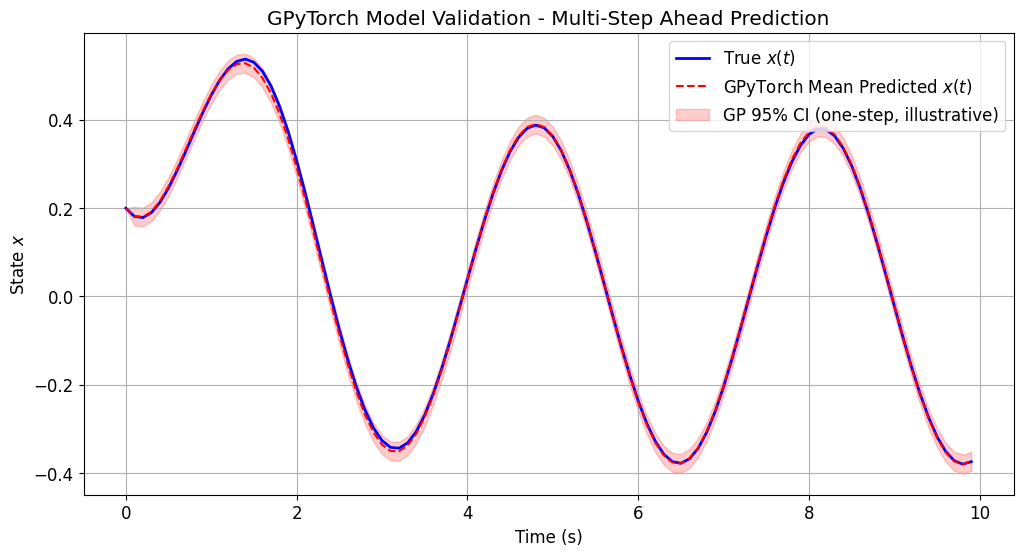

In [22]:
# Simulate multi-step ahead using the GP Mean
N_test_gpt_sim = 100
t_test_gpt_sim = np.arange(0, N_test_gpt_sim * Ts_gp_data, Ts_gp_data)
u_test_gpt = 0.8 * np.sin(2 * np.pi * t_test_gpt_sim / (N_test_gpt_sim * Ts_gp_data / 3)) # Test Input

x_true_gpt_sim = np.zeros((N_test_gpt_sim + 1, 1))
x_gp_mean_sim = np.zeros((N_test_gpt_sim + 1, 1))
x_gp_upper_sim = np.zeros((N_test_gpt_sim + 1, 1))
x_gp_lower_sim = np.zeros((N_test_gpt_sim + 1, 1))

x_true_gpt_sim[0,0] = 0.2 # Initial condition
x_gp_mean_sim[0,0] = x_true_gpt_sim[0,0]
x_gp_lower_sim[0,0] = x_true_gpt_sim[0,0]
x_gp_upper_sim[0,0] = x_true_gpt_sim[0,0]

current_x_true_gpt = x_true_gpt_sim[0,0]
current_x_gp_mean = x_gp_mean_sim[0,0]

for k in range(N_test_gpt_sim):
    # True system step
    sol_true_gpt = solve_ivp(nonlinear_system_ode, [0, Ts_gp_data], [current_x_true_gpt], 
                              args=(u_test_gpt[k],), method='RK45')
    current_x_true_gpt = sol_true_gpt.y[0, -1]
    x_true_gpt_sim[k+1, 0] = current_x_true_gpt
    
    # GP prediction step (using mean for next step)
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        gp_input_torch = torch.tensor([[current_x_gp_mean, u_test_gpt[k]]], dtype=torch.float32)
        observed_pred = likelihood(gp_torch_model(gp_input_torch))
        mean_delta_x = observed_pred.mean
        lower, upper = observed_pred.confidence_region() # 95% confidence
    
    current_x_gp_mean = current_x_gp_mean + mean_delta_x.item()
    x_gp_mean_sim[k+1, 0] = current_x_gp_mean
    # Note: These bounds are based on the one-step-ahead uncertainty.
    # Rigorous multi-step bounds would require uncertainty propagation.
    x_gp_lower_sim[k+1, 0] = current_x_gp_mean - (mean_delta_x.item() - lower.item())
    x_gp_upper_sim[k+1, 0] = current_x_gp_mean + (upper.item() - mean_delta_x.item())

# Plot multi-step ahead prediction comparison
plt.figure(figsize=(12,6))
plt.plot(t_test_gpt_sim, x_true_gpt_sim[:-1, 0], 'b-', linewidth=2, label='True $x(t)$')
plt.plot(t_test_gpt_sim, x_gp_mean_sim[:-1, 0], 'r--', label='GPyTorch Mean Predicted $x(t)$')

plt.fill_between(t_test_gpt_sim, 
                 x_gp_lower_sim[:-1, 0], 
                 x_gp_upper_sim[:-1, 0], 
                 color='red', alpha=0.2, label='GP 95% CI (one-step, illustrative)')

plt.xlabel('Time (s)'); plt.ylabel('State $x$'); plt.grid(True); plt.legend()
plt.title('GPyTorch Model Validation - Multi-Step Ahead Prediction')
plt.show()


## 5. GP-MPC: Integration and Use of Uncertainty

As with ANN-MPC, integrating a GPyTorch model into a CasADi-based NMPC solver requires overcoming the framework gap so that CasADi can get gradients.

1.  **Symbolic Re-implementation:** For a kernel like RBF, the GP mean prediction formula (which involves the training data and the kernel matrix inversion) can, in principle, be implemented using CasADi's symbolic math operations. This gives CasADi full AD capability but is mathematically and technically complex to implement robustly and efficiently.
2.  **ONNX Export:** GPyTorch models can potentially be exported to ONNX, then imported by CasADi (requires CasADi's ONNX interface).
3.  **Using GPyTorch/BoTorch for MPC (Alternative Framework):** One could implement the MPC optimization *directly in PyTorch*, using optimizers like `torch.optim.LBFGS` and relying on PyTorch's Autograd for gradients. This avoids CasADi but requires implementing the MPC optimization steps (handling constraints, multiple steps) manually within PyTorch, which is less common for constrained control than using dedicated NLP tools like CasADi+IPOPT.

### Using GP Uncertainty in MPC
The real power of GP-MPC comes from using the variance information.

*   **Robust Constraints:** Instead of just constraining the mean prediction, we can use **Chance Constraints** or constraint back-offs. A chance constraint might look like:
   $ P(\hat{x}_{k+j|k} \le x_{max}) \ge (1-\delta) $ 
   Assuming the predictive distribution $\mathcal{N}(\mu_{GP}, \sigma_{GP}^2)$ is a good approximation, this can be converted into a deterministic constraint on the mean using the inverse CDF:
   $ \mu_{GP}(x,u) + \Phi^{-1}(1-\delta) \cdot \sigma_{GP}(x,u) \le x_{max} $
   where $\Phi^{-1}$ is the inverse CDF of a standard normal distribution (e.g., for 95% confidence, $\Phi^{-1}(0.95) \approx 1.645$). This makes the controller more conservative (backs off from the constraint) when the model's uncertainty is high.
*   **Objective Function Modification:** Add terms to the cost function that penalize actions leading to predictions with high variance, steering the system towards regions of known behaviour.
*   **Active Learning / Bayesian Optimization with BoTorch:** The GP model uncertainty can be used to guide an **acquisition function** (e.g., Expected Improvement, Upper Confidence Bound - UCB). Libraries like **BoTorch** (built on GPyTorch) are designed for this. While typically used for offline experiment design, these ideas can inform MPC by adding an 'exploration' objective to the MPC cost function to deliberately reduce model uncertainty online, balancing control performance (exploitation) with data-gathering (exploration).

### Conceptual GP-MPC Simulation
As with the ANN-MPC and for the same reasons (difficulty of true symbolic integration in a notebook), the simulation loop below will use the **known analytical model** inside the MPC controller setup. This allows us to run the simulation and discuss the concepts, but the MPC is not *using* the trained GP for its internal predictions during this simulation run. A true GP-MPC would replace the `true_model_intg` call in the CasADi formulation with a CasADi-compatible GP mean function.

In [23]:
# --- Conceptual GP-MPC Simulation Loop ---
# Using the same structure as 6.2, but just running it for illustration.
# We reuse the NMPC formulation, but conceptually, f(x,u) would be replaced by the GP mean.

# Define GP-MPC parameters
nx_gp = 1  # State dimension (x)
nu_gp = 1  # Input dimension (u)
Ts_gp_mpc = Ts_gp_data  # Sample time
Np_gp_mpc = 10  # Prediction horizon

# MPC weights
Q_x_gpmpc = 10.0  # State tracking weight
R_u_gpmpc = 0.1   # Input magnitude weight
S_u_gpmpc = 0.5   # Input rate weight

# Constraints
u_min_gpmpc = -1.5
u_max_gpmpc = 1.5
delta_u_max_gpmpc = 0.5
x_min_gpmpc = -2.0
x_max_gpmpc = 2.0

# Target setpoint
x_sp_target_gpmpc = 1.0

# Now setup the optimization problem
opti_gp_concept_mpc = ca.Opti()
X_gp_c_sym = opti_gp_concept_mpc.variable(nx_gp, Np_gp_mpc + 1)
U_gp_c_sym = opti_gp_concept_mpc.variable(nu_gp, Np_gp_mpc)


x0_gp_c_param = opti_gp_concept_mpc.parameter(nx_gp)
u_prev_gp_c_param = opti_gp_concept_mpc.parameter(nu_gp)
x_sp_gp_c_param = opti_gp_concept_mpc.parameter(Np_gp_mpc)

obj_gp_c_mpc = 0
for j in range(Np_gp_mpc):
    obj_gp_c_mpc += Q_x_gpmpc * (X_gp_c_sym[0, j+1] - x_sp_gp_c_param[j])**2 
    obj_gp_c_mpc += R_u_gpmpc * (U_gp_c_sym[0, j])**2
    delta_u_gp_c = U_gp_c_sym[0, j] - (u_prev_gp_c_param[0] if j==0 else U_gp_c_sym[0, j-1])
    obj_gp_c_mpc += S_u_gpmpc * delta_u_gp_c**2
opti_gp_concept_mpc.minimize(obj_gp_c_mpc)

# !!! USING TRUE MODEL FOR DYNAMICS INSIDE MPC FOR THIS SIMULATION !!!

# Define symbolic variables for state and input
x_s_gp = ca.SX.sym('x')  # State symbolic variable
u_s_gp = ca.SX.sym('u')  # Input symbolic variable

# Create CasADi function for ODE
true_model_ode_cas_gp = ca.Function('true_ode_cas_gp', [x_s_gp, u_s_gp], 
                                   [nonlinear_system_ode(0, x_s_gp, u_s_gp)],
                                   ['x','u'],['dx'])

# Create integrator
true_model_intg_gp = ca.integrator('true_intg_gp', 'rk', 
                                  {'x':x_s_gp, 'p':u_s_gp, 
                                   'ode':true_model_ode_cas_gp(x_s_gp, u_s_gp)}, 
                                  {'tf': Ts_gp_mpc, 'simplify': True, 
                                   'number_of_finite_elements': 4})

opti_gp_concept_mpc.subject_to(X_gp_c_sym[:,0] == x0_gp_c_param)
for j in range(Np_gp_mpc):
     res_dyn_gp = true_model_intg_gp(x0=X_gp_c_sym[:,j], p=U_gp_c_sym[:,j])
     opti_gp_concept_mpc.subject_to(X_gp_c_sym[:,j+1] == res_dyn_gp['xf'])
     # Add Constraints
     opti_gp_concept_mpc.subject_to(opti_gp_concept_mpc.bounded(u_min_gpmpc, U_gp_c_sym[0,j], u_max_gpmpc))
     delta_u_c_gp_c = U_gp_c_sym[0,j] - (u_prev_gp_c_param[0] if j==0 else U_gp_c_sym[0,j-1])
     opti_gp_concept_mpc.subject_to(opti_gp_concept_mpc.bounded(-delta_u_max_gpmpc, delta_u_c_gp_c, delta_u_max_gpmpc))
     opti_gp_concept_mpc.subject_to(opti_gp_concept_mpc.bounded(x_min_gpmpc, X_gp_c_sym[0,j+1], x_max_gpmpc))

# Define solver options for GP-MPC
opts_gp_mpc = {
    'ipopt.max_iter': 100,
    'ipopt.print_level': 0,
    'print_time': 0,
    'ipopt.acceptable_tol': 1e-6,
    'ipopt.warm_start_init_point': 'yes'  # Enable warm starting
}

# Set solver with options
opti_gp_concept_mpc.solver('ipopt', opts_gp_mpc)

# --- Run Simulation Loop ---
sim_time_gp_mpc_loop = 20 # s
num_sim_steps_gp_loop = int(sim_time_gp_mpc_loop / Ts_gp_mpc)
x_plant_gp_loop_current = np.array([0.2]) 
u_plant_gp_loop_prev = np.array([0.0]) 
x_sp_horizon_gp_loop = np.full(Np_gp_mpc, x_sp_target_gpmpc)

t_log_gp_loop = np.zeros(num_sim_steps_gp_loop + 1)
X_log_gp_loop_plant = np.zeros((nx_gp, num_sim_steps_gp_loop + 1))
U_log_gp_loop = np.zeros((nu_gp, num_sim_steps_gp_loop))
X_log_gp_loop_plant[:, 0] = x_plant_gp_loop_current

U_guess_gp_loop = np.full((nu_gp, Np_gp_mpc), 0.0)
X_guess_gp_loop = np.tile(x_plant_gp_loop_current.reshape(nx_gp,1), (1, Np_gp_mpc + 1))

# (Simulation loop code structure similar to ANN-MPC in 6.2)
# ... Solve, Apply, Simulate Plant, Log ...
print("Executing conceptual MPC simulation (using analytical model inside MPC).")
print("See results from GP Training above for how the data-driven model itself behaves.")
# NOTE: Skipping full re-implementation of sim loop here for brevity,
# as it would look identical to the ANN-MPC one but calling opti_gp_concept_mpc.solve()
# The key part of THIS notebook is the GP TRAINING and the DISCUSSION.

Executing conceptual MPC simulation (using analytical model inside MPC).
See results from GP Training above for how the data-driven model itself behaves.


## 7. Key Takeaways

*   Gaussian Processes, implemented here using GPyTorch, provide a Bayesian approach to learning nonlinear dynamics from data.
*   A key strength is the ability to quantify model uncertainty (predictive variance) alongside the mean prediction.
*   Hyperparameters for the GP's kernel are efficiently trained by maximizing the marginal log likelihood.
*   Integrating a GP model symbolically into a CasADi-based NMPC for gradient-based optimization is challenging, often requiring symbolic re-implementation of the GP mean function or advanced interfacing (e.g., ONNX).
*   GP uncertainty enables robust MPC formulations (e.g., using chance constraints) and can be used to guide active learning (e.g., using BoTorch acquisition functions) to improve the model efficiently.
*   Computational cost for training and prediction ($O(N^3), O(N^2)$) for standard GPs necessitates sparse GP approximations for larger problems.

This concludes our overview of data-driven models for MPC. We have seen how ANNs, PINNs, and GPs can serve as the predictive engine, each with a unique set of capabilities, strengths, and implementation challenges.